# Data Exploration

In [1]:
import pandas as pd

df_train = pd.read_csv("dataset/sts-indonesia/train.tsv", sep="\t")
df_train = df_train[["text1_id", "text2_id", "score"]]
df_train

df_test = pd.read_csv("dataset/sts-indonesia/test.tsv", sep="\t")
df_test = df_test[["text1_id", "text2_id", "score"]]
df_test

df = pd.concat([df_train, df_test])
df


,text1_id,text2_id,score
0,Sebuah sepeda motor diparkir di dekat dinding ...,Sebuah sepeda motor diparkir oleh mural sebuah...,3.40
1,"dia menikahimu, memilih untuk memiliki anak be...",mereka tidak pernah mengangkat masalah moral a...,0.50
2,Wanita yang meninggal itu juga mengenakan cinc...,Seorang wanita berambut pirang mengenakan arlo...,2.60
3,Kedua komponen harus berada di jalur tertutup.,bohlam dan baterai berada di jalur tertutup,3.80
4,Seperti yang sudah saya jelaskan pada bacaan k...,Seperti yang telah saya katakan dalam bacaan k...,4.75
...,...,...,...
2575,PM Turki mendesak untuk mengakhiri protes di I...,Polisi Turki menembakkan gas air mata ke pengu...,2.80
2576,Karena tegangannya tidak mencapai bohlam.,jalannya tidak tertutup,1.80
2577,Mereka kemudian jatuh dan telah mendukung sera...,"Kedua negara yang menginvasi kemudian jatuh, d...",3.50
2578,Lem underlayment ke beton: berapa lama waktu y...,Berapa lama waktu yang dibutuhkan untuk menyem...,3.00


<AxesSubplot: >

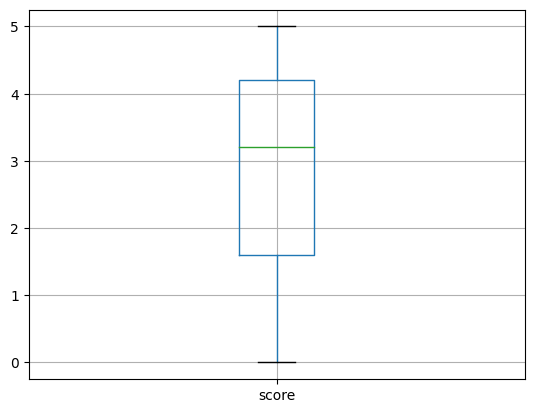

In [2]:
df.boxplot(column=["score"])

array([[<AxesSubplot: title={'center': 'score'}>]], dtype=object)

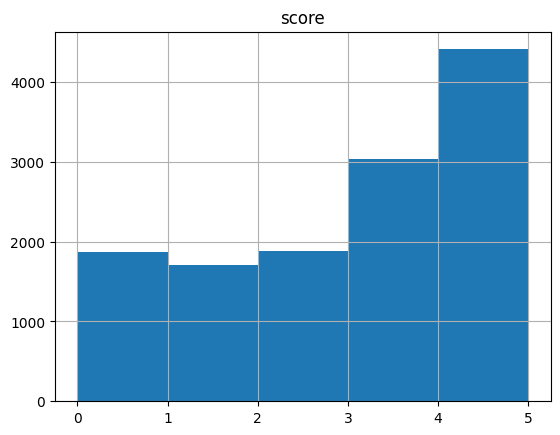

In [2]:
df.hist(bins=5)

Looks like the dataset is skewed to the left

# Data Preprocess

In [31]:
import pandas as pd

df_train = pd.read_csv("dataset/sts-indonesia/train.tsv", sep="\t", nrows=10000)
df_train = df_train[["text1_id", "text2_id", "score"]]
df_train["score"] = df_train["score"] / 5.0
df_train


,text1_id,text2_id,score
0,Sebuah sepeda motor diparkir di dekat dinding ...,Sebuah sepeda motor diparkir oleh mural sebuah...,0.68
1,"dia menikahimu, memilih untuk memiliki anak be...",mereka tidak pernah mengangkat masalah moral a...,0.10
2,Wanita yang meninggal itu juga mengenakan cinc...,Seorang wanita berambut pirang mengenakan arlo...,0.52
3,Kedua komponen harus berada di jalur tertutup.,bohlam dan baterai berada di jalur tertutup,0.76
4,Seperti yang sudah saya jelaskan pada bacaan k...,Seperti yang telah saya katakan dalam bacaan k...,0.95
...,...,...,...
9995,Semua ada di kepalanya.,Ini semua tentang adhesi.,0.00
9996,"Ketika kita dihadapkan pada risiko potensial, ...",Ketika kita dihadapkan dengan risiko potensial...,0.96
9997,"Tn. Drummond, ya ... menunjukkan umur saya: Co...","Conrad Bain, Aktor di? Diff? Rent Strokes ,? M...",0.84
9998,Capitol AS dievakuasi kemarin setelah pihak be...,Polisi Capitol AS mengevakuasi Capitol kemarin...,0.64


In [32]:
df_test = pd.read_csv("dataset/sts-indonesia/test.tsv", sep="\t", nrows=1000)
df_test = df_test[["text1_id", "text2_id", "score"]]
df_test["score"] = df_test["score"] / 5.0
df_test

,text1_id,text2_id,score
0,Partai oposisi Thailand memboikot pemilihan umum,Oposisi Thailand mengumumkan boikot pemilu,0.96
1,"WHO mengatakan, kasus terbaru tidak sesuai den...",WHO mengatakan kasus Singapura tidak sesuai de...,0.76
2,"Banyak orang yang mengikuti balap sepeda, term...",Seorang lelaki mengendarai kursi roda tiga.,0.52
3,Jeff Bezos bertaruh $ 250 Juta untuk Menghidup...,Jeff Bezos Membayar $ 250 Juta Untuk The Washi...,0.84
4,perbatasan atau batas suatu objek,"merencanakan, mengatur, dan melaksanakan (suat...",0.00
...,...,...,...
995,Seorang pria menyemprotkan cairan dari selang ...,Seorang pria duduk di sepedanya dengan satu ro...,0.12
996,Upaya tersebut merupakan upaya terbaru pemerin...,10 Juli - Upaya terbaru pemerintah Bush untuk ...,0.65
997,Haruskah saya memberi tahu calon pemberi kerja...,Haruskah saya memberi tahu bos saya bahwa saya...,0.60
998,Ratu Beatrix dari Belanda akan turun tahta unt...,Ratu Beatrix dari Belanda mengundurkan diri de...,1.00


# Model Construction

#### Architecture Initialization

In [33]:
from sentence_transformers import SentenceTransformer, InputExample, models

# TODO: try more complex architecture
word_embedding_model = models.Transformer('bert-base-uncased', max_seq_length=256)

# TODO: add dense layer
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode="mean")

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### Training Part

In [34]:
from torch.utils.data import DataLoader
from sentence_transformers import losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

# create a train examples to be used in DataLoader
train_examples = []
for i, row in df_train.iterrows():
    train_examples.append(InputExample(texts=[row["text1_id"], row["text2_id"]], label=row["score"]))

# we wrap our train_examples with the standard PyTorch DataLoader, which shuffles our data and produces batches of certain sizes.
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

# define the loss function
# TODO: use and experiment with another loss functions
train_loss = losses.CosineSimilarityLoss(model)

# define the evaluator
# evaluate a model based on the similarity of the embeddings by calculating the Spearman and Pearson rank correlation in comparison to the gold standard labels
# https://github.com/UKPLab/sentence-transformers/blob/83eeb5a7b9b81d17a235d76e101cc2912ee1a30d/examples/evaluation/evaluation_stsbenchmark.py#L10
# TODO: this one should be a dev_examples not test_examples
test_examples = []
for i, row in df_test.iterrows():
    test_examples.append(InputExample(texts=[row["text1_id"], row["text2_id"]], label=row["score"]))
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_examples)

# tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100, evaluator=evaluator)

# TODO: create a new embedding evaluator with test dataset (not dev dataset) and then evaluate the finetuned model here
model.evaluate(evaluator)


Epoch: 100%|██████████| 1/1 [36:12<00:00, 2172.30s/it]


0.6680118226204218

Usage of bert-base-uncased + indonesian sts seems pretty bad. Will try to use indoBERT as the base model

# Experiments

Experiment 1: will try to use indoBERT as the base word embedding BERT model

In [35]:
from sentence_transformers import SentenceTransformer, InputExample, models

word_embedding_model = models.Transformer('indolem/indobert-base-uncased', max_seq_length=256)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), pooling_mode="mean")

model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

from torch.utils.data import DataLoader
from sentence_transformers import losses
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

train_examples = []
for i, row in df_train.iterrows():
    train_examples.append(InputExample(texts=[row["text1_id"], row["text2_id"]], label=row["score"]))

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model)

test_examples = []
for i, row in df_test.iterrows():
    test_examples.append(InputExample(texts=[row["text1_id"], row["text2_id"]], label=row["score"]))
evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_examples)

model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=1, warmup_steps=100, evaluator=evaluator)
model.evaluate(evaluator)


Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Epoch: 100%|██████████| 1/1 [18:58<00:00, 1138.19s/it]


0.7773440751254502

Using IndoBERT shows the score is much better than using basic bert model with score 77.73 

# Inference

After we got the model, we will use the model to make the score of our dataset

In [7]:
from sentence_transformers import SentenceTransformer, util

def find_similarity(model: SentenceTransformer, sentence1: str, sentence2: str) -> float:
    embeddings1 = model.encode(sentence1, convert_to_tensor=True)
    embeddings2 = model.encode(sentence2, convert_to_tensor=True)

    cosine_scores = util.cos_sim(embeddings1, embeddings2)
    return float(cosine_scores[0][0])

model = SentenceTransformer("all-MiniLM-L6-v2")
score_inference = []
for index, row in df.iterrows():
    row_score = find_similarity(model, sentence1=row["text1_id"], sentence2=row["text2_id"]) * 5
    score_inference.append(row_score)

df["score_inference"] = score_inference
df

,text1_id,text2_id,score,score_inference
0,Sebuah sepeda motor diparkir di dekat dinding ...,Sebuah sepeda motor diparkir oleh mural sebuah...,3.40,0.768838
1,"dia menikahimu, memilih untuk memiliki anak be...",mereka tidak pernah mengangkat masalah moral a...,0.50,0.600113
2,Wanita yang meninggal itu juga mengenakan cinc...,Seorang wanita berambut pirang mengenakan arlo...,2.60,0.708318
3,Kedua komponen harus berada di jalur tertutup.,bohlam dan baterai berada di jalur tertutup,3.80,0.733746
4,Seperti yang sudah saya jelaskan pada bacaan k...,Seperti yang telah saya katakan dalam bacaan k...,4.75,0.833272
...,...,...,...,...
2575,PM Turki mendesak untuk mengakhiri protes di I...,Polisi Turki menembakkan gas air mata ke pengu...,2.80,0.662744
2576,Karena tegangannya tidak mencapai bohlam.,jalannya tidak tertutup,1.80,0.525529
2577,Mereka kemudian jatuh dan telah mendukung sera...,"Kedua negara yang menginvasi kemudian jatuh, d...",3.50,0.637883
2578,Lem underlayment ke beton: berapa lama waktu y...,Berapa lama waktu yang dibutuhkan untuk menyem...,3.00,0.698352


In [8]:
df.hist(column="score_inferenece", bins=5)

In [9]:
df

,text1_id,text2_id,score,score_inference
0,Sebuah sepeda motor diparkir di dekat dinding ...,Sebuah sepeda motor diparkir oleh mural sebuah...,3.40,3.844191
1,"dia menikahimu, memilih untuk memiliki anak be...",mereka tidak pernah mengangkat masalah moral a...,0.50,3.000567
2,Wanita yang meninggal itu juga mengenakan cinc...,Seorang wanita berambut pirang mengenakan arlo...,2.60,3.541591
3,Kedua komponen harus berada di jalur tertutup.,bohlam dan baterai berada di jalur tertutup,3.80,3.668731
4,Seperti yang sudah saya jelaskan pada bacaan k...,Seperti yang telah saya katakan dalam bacaan k...,4.75,4.166360
...,...,...,...,...
2575,PM Turki mendesak untuk mengakhiri protes di I...,Polisi Turki menembakkan gas air mata ke pengu...,2.80,3.313722
2576,Karena tegangannya tidak mencapai bohlam.,jalannya tidak tertutup,1.80,2.627643
2577,Mereka kemudian jatuh dan telah mendukung sera...,"Kedua negara yang menginvasi kemudian jatuh, d...",3.50,3.189416
2578,Lem underlayment ke beton: berapa lama waktu y...,Berapa lama waktu yang dibutuhkan untuk menyem...,3.00,3.491758
